In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDClassifier, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error, accuracy_score, \
    confusion_matrix, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('../data/processed/cars_clean.csv')
print(f"updated types:\n{df.dtypes}\n")
print(f"updated missing values counts:\n{df.isnull().sum()}\n")
print(f"data columns: {df.columns}\n")

# best choice: frequency encoding
print(f"unique man ids: {df['manufacturer'].nunique()}")
print(f"unique model ids: {df['model'].nunique()}")

freq_manufacturer = df['manufacturer'].value_counts(normalize=True)
df['manufacturer_freq'] = df['manufacturer'].map(freq_manufacturer)

freq_model = df['model'].value_counts(normalize=True)
df['model_freq'] = df['model'].map(freq_model)

df = df.drop(columns=['manufacturer', 'model'])

# best choice: one hot encoding
print(f"unique fuel types: {df['fuel_type'].nunique()}")
print(f"unique gear types: {df['gear_type'].nunique()}")
print(f"unique drive types: {df['drive_type'].nunique()}")
print(f"unique color types: {df['color'].nunique()}")
print(f"unique car categories: {df['category'].nunique()}")

categorical_cols = ['fuel_type', 'gear_type', 'drive_type', 'color', 'category']

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
old_df = df.copy()

updated types:
car_id                     int64
price                    float64
car_age                    int64
engine_volume            float64
cylinders                  int64
car_run_km               float64
safety_feature_count       int64
comfort_feature_count      int64
manufacturer              object
model                     object
fuel_type                 object
gear_type                 object
drive_type                object
color                     object
category                  object
abs                        int64
esd                        int64
el_windows                 int64
conditioner                int64
leather                    int64
hydraulics                 int64
chair_warming              int64
climat_control             int64
customs_passed             int64
tech_inspection            int64
has_turbo                  int64
right_wheel                int64
start_stop                 int64
back_camera                int64
is_dealer                  i

In [23]:
df = df.drop(columns=['car_id'])
X = df.drop(columns=['price'])
y = df['price']

# need this for later
feature_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [24]:
def train_with_linear_reg(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def train_with_lasso(X_train, y_train, max_iter=1000):
    model = Lasso(max_iter=max_iter)
    model.fit(X_train, y_train)
    return model

def train_with_ridge(X_train, y_train):
    model = Ridge()
    model.fit(X_train, y_train)
    return model

def train_with_decision_tree(X_train, y_train, max_depth=10):
    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(X_train, y_train)
    return model

def train_with_random_forest(X_train, y_train, n_estimators=100):
    model = RandomForestRegressor(n_estimators=n_estimators)
    model.fit(X_train, y_train)
    return model

def predict(X_test, model):
    y_pred = model.predict(X_test)
    return y_pred

def calc_metrics(y_pred, y):
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred)
    return r2, mse, mae, rmse


In [25]:
# Train each model
linear_reg = train_with_linear_reg(X_train, y_train)
lasso = train_with_lasso(X_train, y_train)
ridge = train_with_ridge(X_train, y_train)
decision_tree = train_with_decision_tree(X_train, y_train)
random_forest = train_with_random_forest(X_train, y_train)

# Evaluate results for all models
models = {
    'Linear_Reg': linear_reg,
    'Lasso': lasso,
    'Ridge': ridge,
    'Decision_Tree': decision_tree,
    'RandomForest': random_forest
}

results = []
random_forest_pred = []

for name, model in models.items():
    print(f"Model: {name}")

    # predictions
    y_pred = predict(X_test, model)
    if name == 'RandomForest':
        random_forest_pred = y_pred

    # calculate metrics
    r2, mse, mae, rmse = calc_metrics(y_pred, y_test)

    results.append({
        'Model': name,
        'R2': r2,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse
    })

# Comparison Table
results_df = pd.DataFrame(results)
print(f"\n{'='*50}")
print("MODEL COMPARISON TABLE")
print(f"{'='*50}")
print(results_df.to_string(index=False))


Model: Linear_Reg
Model: Lasso
Model: Ridge
Model: Decision_Tree
Model: RandomForest

MODEL COMPARISON TABLE
        Model       R2          MSE         MAE        RMSE
   Linear_Reg 0.489065 4.449066e+07 4251.829630 6670.131733
        Lasso 0.489111 4.448665e+07 4250.192783 6669.831690
        Ridge 0.489069 4.449028e+07 4251.713621 6670.103669
Decision_Tree 0.761478 2.076980e+07 2210.305283 4557.389942
 RandomForest 0.855727 1.256281e+07 1723.408919 3544.404771


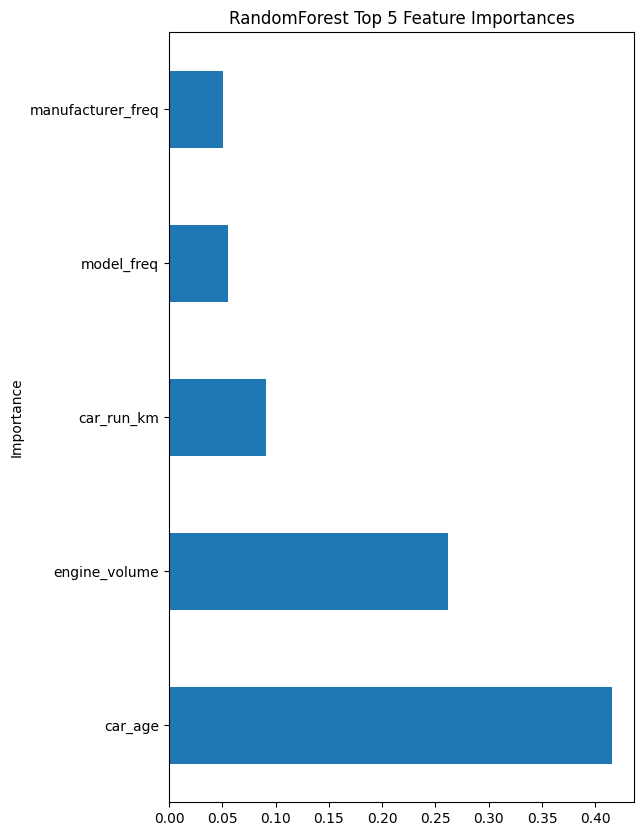

In [26]:
# Feature importance from RandomForest
rf_importance = pd.Series(random_forest.feature_importances_, index=feature_names)
rf_importance = rf_importance.sort_values(ascending=False)

plt.figure(figsize=(6, 10))

rf_importance.head().plot(kind='barh')
plt.title("RandomForest Top 5 Feature Importances")
plt.ylabel("Importance")
plt.show()

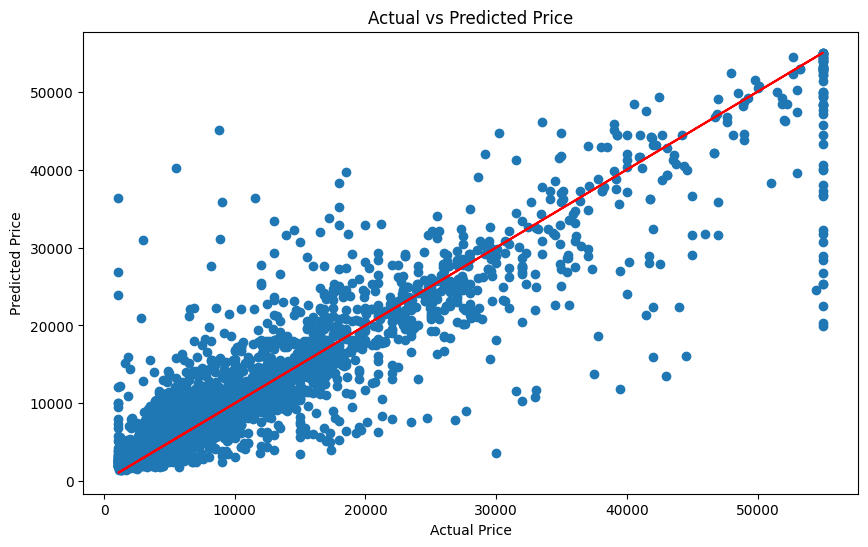

In [27]:
# predicted vs actual price plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, random_forest_pred)
plt.plot(y_test, y_test, color='red')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()


In [28]:
import joblib
from pathlib import Path

# Saving model

# Ensure the models directory exists
models_dir = Path('../models')
models_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(random_forest, models_dir / 'random_forest_model.pkl')
joblib.dump(feature_names, models_dir / 'model_features.pkl')

['../models/model_features.pkl']

## Classification

In [29]:
# introduce price_class column for classification target
old_df['price_class'] = pd.qcut(
    old_df['price'],
    q=4,
    labels=['Low', 'Mid', 'High', 'Luxury']
)

X = old_df.drop(columns=['price', 'price_class'])
y = old_df['price_class']


# need this for later
feature_names_clf = X.columns

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_clf = StandardScaler()
X_train_clf = scaler_clf.fit_transform(X_train_clf)
X_test_clf = scaler_clf.transform(X_test_clf)


In [30]:
def train_with_logistic_reg(X_train, y_train, max_iter=1000):
    model = LogisticRegression(max_iter=max_iter)
    model.fit(X_train, y_train)
    return model

def train_with_SGD(X_train, y_train, alpha=0.001, max_iter=1000):
    model = SGDClassifier(alpha=alpha, max_iter=max_iter)
    model.fit(X_train, y_train)
    return model

def train_with_decision_tree_classifier(X_train, y_train, max_depth=10):
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(X_train, y_train)
    return model

def train_with_random_forest_classifier(X_train, y_train, n_estimators=100):
    model = RandomForestClassifier(n_estimators=n_estimators)
    model.fit(X_train, y_train)
    return model

def predict(X_test, model):
    y_pred = model.predict(X_test)
    return y_pred

def calc_classifier_metrics(y_pred, y):
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='macro', zero_division=0)
    recall = recall_score(y, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y, y_pred, average='macro', zero_division=0)
    matrix = confusion_matrix(y, y_pred)
    return accuracy, precision, recall, f1, matrix


In [37]:
# Train each model
logistic_reg = train_with_logistic_reg(X_train_clf, y_train_clf)
SGD = train_with_SGD(X_train_clf, y_train_clf)
decision_tree = train_with_decision_tree_classifier(X_train_clf, y_train_clf)
random_forest = train_with_random_forest_classifier(X_train_clf, y_train_clf)

# Evaluate results for all models
models = {
    'Logistic_Reg': logistic_reg,
    'SGD': SGD,
    'Decision_Tree': decision_tree,
    'RandomForest': random_forest
}

results = []
matrices = []
random_forest_pred = []

for name, model in models.items():
    print(f"Model: {name}")

    # predictions
    y_pred = predict(X_test_clf, model)
    if name == 'RandomForest':
        random_forest_pred = y_pred

    # calculate metrics
    accuracy, precision, recall, f1, matrix = calc_classifier_metrics(y_pred, y_test_clf)

    matrices.append({
        'Model': name,
        'Confusion_Matrix': matrix
    })

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

# comparison Table
results_df = pd.DataFrame(results)
print(f"\n{'='*50}")
print("MODEL COMPARISON TABLE")
print(f"{'='*50}")
print(results_df.to_string(index=False))


Model: Logistic_Reg
Model: SGD
Model: Decision_Tree
Model: RandomForest

MODEL COMPARISON TABLE
        Model  Accuracy  Precision   Recall       F1
 Logistic_Reg  0.697607   0.694463 0.700083 0.695543
          SGD  0.586796   0.554952 0.591689 0.538127
Decision_Tree  0.715596   0.715664 0.718112 0.714915
 RandomForest  0.774240   0.773883 0.776127 0.774077


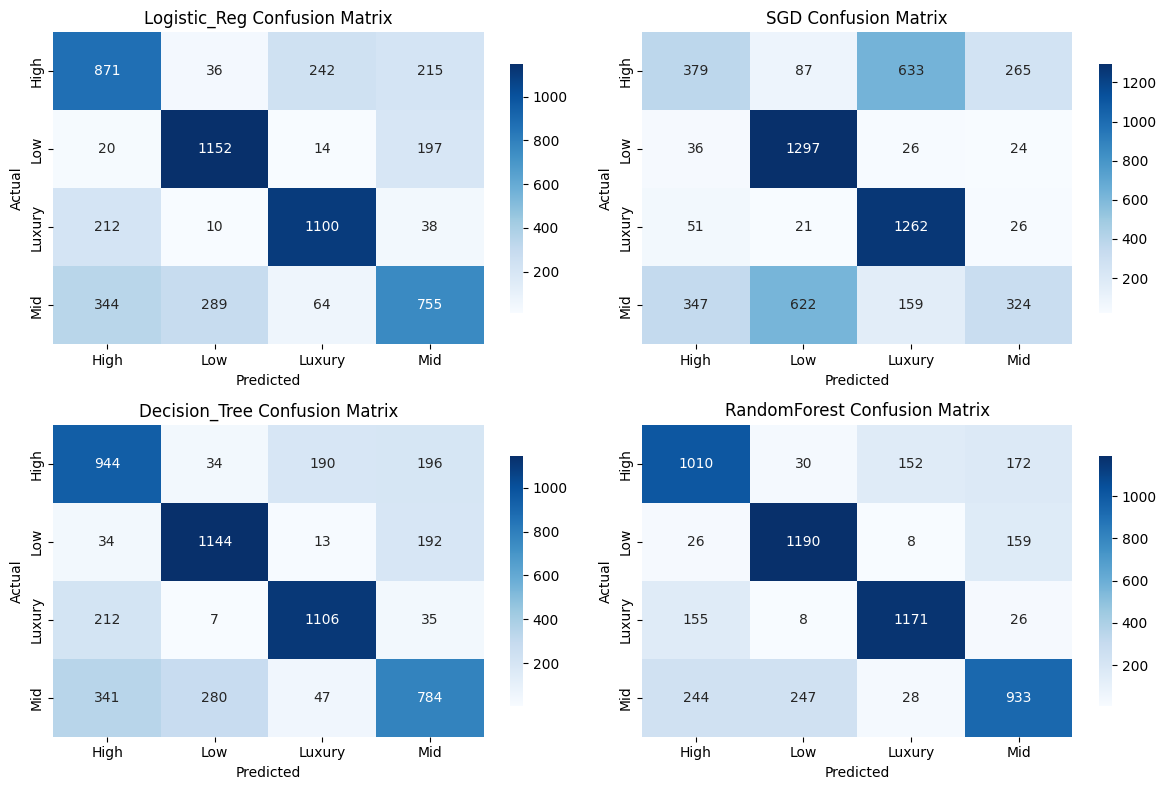

In [38]:
# Visualize confusion matrices as heatmaps
categories = sorted(y_test_clf.unique())

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for idx, matrix_dict in enumerate(matrices):
    model_name = matrix_dict['Model']
    matrix = matrix_dict['Confusion_Matrix']

    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=categories, yticklabels=categories,
                ax=axes[idx], cbar_kws={'shrink': 0.8})
    axes[idx].set_title(f'{model_name} Confusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

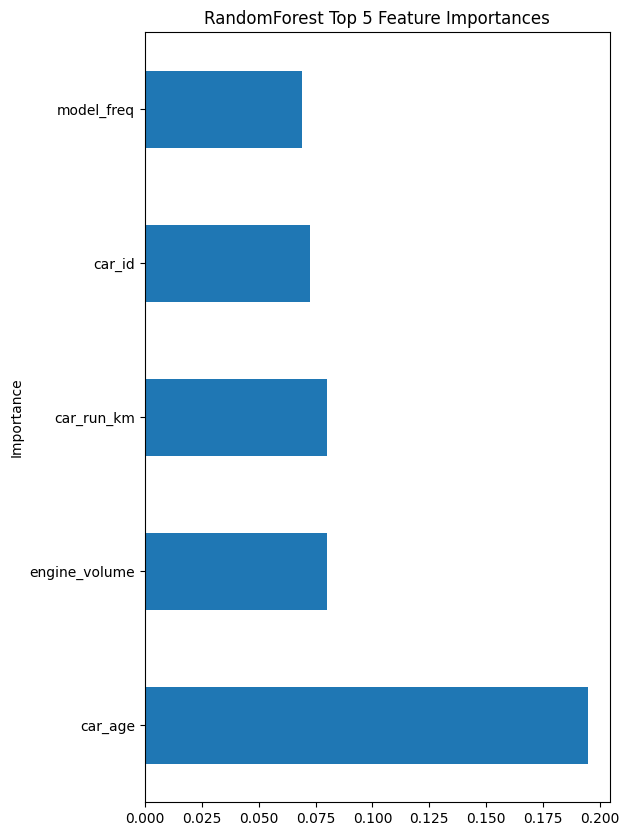

In [33]:
# Feature importance from RandomForest
rf_importance = pd.Series(random_forest.feature_importances_, index=feature_names_clf)
rf_importance = rf_importance.sort_values(ascending=False)

plt.figure(figsize=(6, 10))

rf_importance.head().plot(kind='barh')
plt.title("RandomForest Top 5 Feature Importances")
plt.ylabel("Importance")
plt.show()